## <center> CS559 Machine Learning: Fundamentals and Applications</center>
<center> Fall 2022 HW5</center>
<center>Due: 12/16/2022 Friday 11:59 PM </center>

Homework assignments will be done individually: each student must hand in their own answers. Use of partial or entire solutions obtained from others or online is strictly prohibited. Electronic submission on Canvas is mandatory.

# Graphical Models (30 pts)

Consider following tables:

||p(C)|
|----|----|
|F|0.65|
|T|0.35|

|C|p(S=F)|p(S=T)|p(R=F)|p(R=T)|
|--|--|--|--|--|
|F|0.7|0.3|0.8|0.2|
|T|0.8|0.2|0.2|0.8|

|S|R|p(W=T)|p(W=F)|
|-|-|---|---|
|F|F|0.96|0.04|
|T|F|0.15|0.85|
|F|T|0.17|0.83|
|T|T|0.02|0.98|

a.	(5 pts) Using pgmpy, draw a conditional directed graph.

In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

import daft
from daft import PGM

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
model = BayesianNetwork([('C', 'S'), ('C', 'R'), ('S', 'W'), ('R', 'W')])

In [3]:
cpd_c = TabularCPD(variable='C', variable_card=2, values=[[0.65], [0.35]])

cpd_s = TabularCPD(variable='S', variable_card=2,
                    values=[[0.8, 0.2],
                            [0.2, 0.8]],
                    evidence=['C'],
                    evidence_card=[2])
        
cpd_r = TabularCPD(variable='R', variable_card=2,
                    values=[[0.7, 0.8],
                            [0.3, 0.2]],
                    evidence=['C'],
                    evidence_card=[2])

cpd_w = TabularCPD(variable='W', variable_card=2,
                    values=[[0.04, 0.85, 0.83, 0.98],
                            [0.96, 0.15, 0.17, 0.02]],
                    evidence=['R', 'S'],
                    evidence_card=[2, 2])

In [4]:
model.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

In [5]:
model.check_model()

True

In [6]:
model.get_cpds()

[<TabularCPD representing P(C:2) at 0x125c633ecd0>,
 <TabularCPD representing P(S:2 | C:2) at 0x125c62fcfd0>,
 <TabularCPD representing P(R:2 | C:2) at 0x125c633ed00>,
 <TabularCPD representing P(W:2 | R:2, S:2) at 0x125c633eca0>]

In [7]:
print(cpd_c)

+------+------+
| C(0) | 0.65 |
+------+------+
| C(1) | 0.35 |
+------+------+


In [8]:
print(cpd_r)

+------+------+------+
| C    | C(0) | C(1) |
+------+------+------+
| R(0) | 0.7  | 0.8  |
+------+------+------+
| R(1) | 0.3  | 0.2  |
+------+------+------+


In [9]:
print(cpd_s)

+------+------+------+
| C    | C(0) | C(1) |
+------+------+------+
| S(0) | 0.8  | 0.2  |
+------+------+------+
| S(1) | 0.2  | 0.8  |
+------+------+------+


In [10]:
print(cpd_w)

+------+------+------+------+------+
| R    | R(0) | R(0) | R(1) | R(1) |
+------+------+------+------+------+
| S    | S(0) | S(1) | S(0) | S(1) |
+------+------+------+------+------+
| W(0) | 0.04 | 0.85 | 0.83 | 0.98 |
+------+------+------+------+------+
| W(1) | 0.96 | 0.15 | 0.17 | 0.02 |
+------+------+------+------+------+


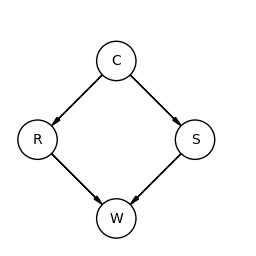

In [11]:
pgm = PGM(shape=[3, 3])

pgm.add_node(daft.Node('C', r"C", 2, 3))
pgm.add_node(daft.Node('W', r"W", 2, 1))
pgm.add_node(daft.Node('R', r"R", 1, 2))
pgm.add_node(daft.Node('S', r"S", 3, 2))

pgm.add_edge('C', 'R')
pgm.add_edge('C', 'S')
pgm.add_edge('R', 'W')
pgm.add_edge('S', 'W')

pgm.render()
plt.show()

b.	(5 pts) Calculate a probability p(C,S,R,W).

In [12]:
from pgmpy.inference import VariableElimination

In [13]:
solver = VariableElimination(model)

In [14]:
# p(C,S,R,W) = p(C)p(S|C)p(R|C)p(W|S,R)

# p(C)
res1 = solver.query(variables=['C'])

# p(S|C)
res2 = solver.query(variables=['S'], evidence={'C': 1})

# p(R|C)
res3 = solver.query(variables=['R'], evidence={'C': 1})

# p(W|S,R)
res4 = solver.query(variables=['W'], evidence={'R': 1, 'S': 1})

result = solver.query(variables=['C', 'S', 'R', 'W'])

#print(f"p(C,S,R,W): {result.values}")
print(f"p(C,S,R,W): {res1.values[1] * res2.values[1] * res3.values[1] * res4.values[1]}")

p(C,S,R,W): 0.00112


c.	(5 pts) Calculate a probability p(S=T|W=T).

In [15]:
result = solver.query(variables=['S'], evidence={'W': 1})
print(f"p(S=T|W=T): {result.values[1]}")

p(S=T|W=T): 0.10212987012987011


d.	(10 pts) Using a provided data table, `GM_train.csv`, train a graphical model using `pgmpy.models.BayesianModel` and report the accuracy. The target is W. 

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [17]:
gm_train = pd.read_csv("GM_train.csv")

In [18]:
gm_train.head()

,C,S,R,W
0,0,1,1,0
1,0,1,1,0
2,1,1,0,0
3,0,1,1,0
4,1,0,0,1


In [19]:
model.fit(gm_train)
print(model.get_cpds('W'))

+------+------+------+---------------------+--------------------+
| R    | R(0) | R(0) | R(1)                | R(1)               |
+------+------+------+---------------------+--------------------+
| S    | S(0) | S(1) | S(0)                | S(1)               |
+------+------+------+---------------------+--------------------+
| W(0) | 0.56 | 0.65 | 0.46153846153846156 | 0.5517241379310345 |
+------+------+------+---------------------+--------------------+
| W(1) | 0.44 | 0.35 | 0.5384615384615384  | 0.4482758620689655 |
+------+------+------+---------------------+--------------------+


In [20]:
y_pred_train = model.predict(gm_train.drop('W', axis=1))
accuracy_score(gm_train['W'], y_pred_train)

  0%|          | 0/8 [00:00<?, ?it/s]

0.57

e.	(5 pts) Generalize the model trained in **d** using `GM_test.csv`.

In [21]:
gm_test = pd.read_csv("GM_test.csv")

In [22]:
gm_test.head()

,C,S,R,W
0,1,0,0,1
1,0,1,1,1
2,1,1,1,1
3,0,0,1,1
4,1,1,1,1


In [23]:
y_pred_test = model.predict(gm_test.drop('W', axis=1))
accuracy_score(gm_test['W'], y_pred_test)

  0%|          | 0/8 [00:00<?, ?it/s]

0.56

# Handwriting recognition: (70 pts)
Handwriting recognition is a well-studied subject in computer vision and has found wide applications in our daily life (such as USPS mail sorting). In this project, we will explore various machine learning techniques for recognizing handwriting digits. The dataset you will be using is the well-known MINST dataset.

(1)	The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. (http://yann.lecun.com/exdb/mnist/)

(2)	Below is an example of some digits from the MNIST dataset.

![Image of MINST](https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp)

(3)	The goal of this assignment is to build a 10-class classifier to recognize those handwriting digits as accurately as you can.  All the assignments below should use the training data (60K examples) and test data (10 K examples) as given by the dataset.

a.	(30 pts) Build several non-deep learning based classifiers using all pixels as features for handwriting recognition. You need to use at least **three techniques** we have learned from the class to do the work.

In [24]:
df_train = pd.read_csv("mnist-in-csv/mnist_train.csv")
df_test = pd.read_csv("mnist-in-csv/mnist_test.csv")

In [25]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

# K-Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [27]:
# elbow method

error_rate = []

for i in range(1, 6):
    print(f"K-value: {i}")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test))

K-value: 1
K-value: 2
K-value: 3
K-value: 4
K-value: 5


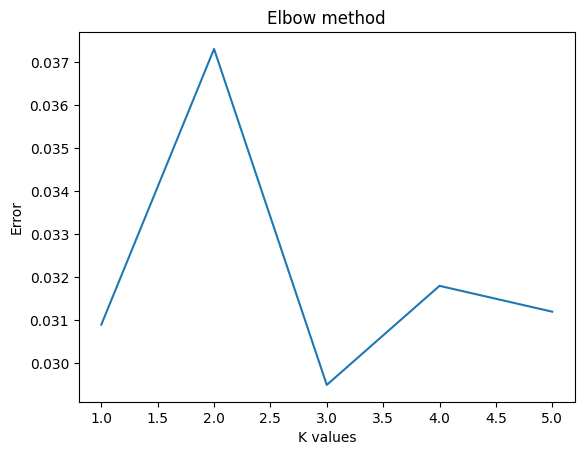

In [28]:
plt.xlabel("K values")
plt.ylabel("Error")
plt.title("Elbow method")
plt.plot(range(1,6), error_rate)
plt.show()

In [29]:
# lowest error at K=3

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [30]:
print(f"Accuracy: {knn.score(X_test, y_test)}")
print(f"Error rate: {np.mean(y_pred != y_test)}")

Accuracy: 0.9705
Error rate: 0.0295


# Support Vector Machines

In [31]:
from sklearn.svm import SVC

In [32]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [33]:
print(f"Accuracy: {svm.score(X_test, y_test)}")
print(f"Error rate: {np.mean(y_pred != y_test)}")

Accuracy: 0.9792
Error rate: 0.0208


# Gaussian Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [36]:
print(f"Accuracy: {gnb.score(X_test, y_test)}")
print(f"Error rate: {np.mean(y_pred != y_test)}")

Accuracy: 0.5558
Error rate: 0.4442


b.	(10 pts) In this assignment, we will explore various techniques related to a neural network with hidden layers of more than 3 to solve the 10-class classification problem.

Since there are many existing implementations to solve the MINST problem, we need to give some twists to this problem to make it worthwhile to do for our final assignment. (Please refer to the ranking list for MNIST at http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html.)

The basic network structure that we are trying to explore is something like the following (i.e., the fully connected deep neural nets). The number of hidden layers and the size of each hidden layer in terms of neurons are left as tuning parameters that you can explore.

![Image of NN](https://pimages.toolbox.com/wp-content/uploads/2022/05/18113202/The-Architecture-of-a-Neural-Network.png)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
train = pd.read_csv("mnist-in-csv/mnist_train.csv")
test = pd.read_csv("mnist-in-csv/mnist_test.csv")

In [39]:
train_x = train.drop('label', axis=1)
train_y = train['label']

test_x = test.drop('label', axis=1)
test_y = test['label']

In [40]:
train_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

test_x.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

In [41]:
# transform csv data into image
# adding one dimension for network
train_transform = transforms.Compose(([transforms.ToPILImage(), transforms.RandomCrop(28), transforms.ToTensor()]))
test_transform = transforms.Compose(([transforms.ToPILImage(), transforms.ToTensor()]))

In [42]:
class MNIST(torch.utils.data.Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
                    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.array(data).astype(np.uint8).reshape(28, 28, 1) 
        
        if self.transforms:
            data = self.transforms(data)
        
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [43]:
mnist_train = MNIST(train_x, train_y, train_transform)
mnist_test = MNIST(test_x, test_y, test_transform)

In [44]:
num_classes = 10

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # network layers
        # conv1: 1 -> 32 channels, 5x5 kernel with stride of 1
        # bn1: Batch Normalization
        # conv2: 32 -> 64 channels, 5x5 kernel with stride of 1
        # bn2: Batch Normalization
        # conv3: 64 -? 128 channels, 3x3 kernel with stride of 1
        # bn3: Batch Normalization
        # fc1: 4608 -> 1024 -> BN
        # fc2: 1024 -> 512 -> BN
        # fc3: 512 -> 256 -> BN
        # fc4: 256 -> 64 -> BN
        # output: 64 -> 10
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(num_features=128)
        
        self.fc1 = nn.Linear(in_features=128*6*6, out_features=1024)
        self.fc1_bn = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc2_bn = nn.BatchNorm1d(num_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.fc3_bn = nn.BatchNorm1d(num_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=64)
        self.fc4_bn = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, t):
        t = F.relu(self.conv1_bn(self.conv1(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2_bn(self.conv2(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv3_bn(self.conv3(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=1)
        
        t = F.relu(self.fc1_bn(self.fc1(t.reshape(-1, 128*6*6))))
        t = F.relu(self.fc2_bn(self.fc2(t)))
        t = F.relu(self.fc3_bn(self.fc3(t)))
        t = F.relu(self.fc4_bn(self.fc4(t)))
        t = self.out(t)
        
        return t

In [45]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [46]:
epochs = 3
batch_size = 250

lr = 1e-3

model = Network().to(device)
train_dl = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(network.parameters(), lr=lr)

for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    epoch_loss = 0
    epoch_correct = 0
    model.train()
    
    for images, labels in train_dl:
        X, y = images.to(device), labels.to(device)
        y_ = model(X)
        
        optimizer.zero_grad()
        loss = F.cross_entropy(y_, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_size
        epoch_correct += get_num_correct(y_, y)
        
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_dl:
            X, y = images.to(device), labels.to(device)
            
            preds = model(X)
            loss = F.cross_entropy(preds, y)
            
            test_correct += get_num_correct(preds, y)
            test_loss = loss.item() * batch_size

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {(test_correct/len(test_x)) * 100}")
    print("\n")

Epoch:  1
Test Loss: 1.5526249073445797
Test Accuracy: 98.41


Epoch:  2
Test Loss: 0.8487559854984283
Test Accuracy: 98.96000000000001


Epoch:  3
Test Loss: 0.1961404224857688
Test Accuracy: 98.92999999999999


Epoch:  4


KeyboardInterrupt: 

c.	(30 pts) This assignment reflects the data collection process.
- Hand write 5 styles of your own digits from 0 to 9 on a paper, and make sure your own handwritings are for sure recognizable by yourself. Please take a picture of each digit you write (so you have total 5 x 10 = 50 images), resize and convert it to the same data input format as the MNIST dataset. In other words, you have 50 new data points with labels.
- Treat these 50 images as “brand-new” test dataset and run your own ML models from Question a and b on these 50 images and report the achieved test accuracy. Note, the goal for this exercise is not for achieving “high” accuracy, but to show what potential gaps there may be between existing MNIST dataset and your own test dataset, a scenario you would encounter in real life.
- Use the following code for the image loading. 


In [47]:
#Import the Photos
from matplotlib import pyplot as plt
import cv2
import os

rootdir = "mnist-custom/"

def read_img(img_path):
    img = cv2.imread(img_path)
    x_img = np.array([0] * 784)


    for i in range(28):
        for j in range(28):
            idx = i * 28 + j
            x_img[idx] = 255 - img[i][j][0]
            
    return x_img, img
    
X_mydigits = []
Y_mydigits = []
digit_imgs = []

# read handwritten digits
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(subdir, file)
            digit, img = read_img(path)
            label = int(os.path.splitext(subdir)[0][-1])
            X_mydigits.append(digit)
            Y_mydigits.append(label)
            digit_imgs.append(img)


X_mydigits = np.array(X_mydigits)
Y_mydigits = np.array(Y_mydigits)

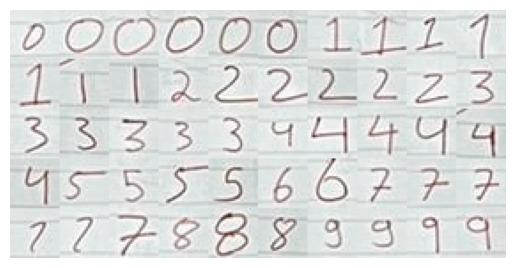

In [48]:
#Showing all my images
temp_img = 'mnist-custom/0/file1.jpg'
for i in range(5):
    hor = 'mnist-custom/1/file2.jpg'
    for j in range(10):
        idx = i*10 + j
        img = digit_imgs[idx]
        if j == 0:
            hor = img
        else:
            hor = np.hstack((hor, img))
    if i == 0:
        temp_img = hor
    else:
        temp_img = np.vstack((temp_img, hor))

plt.imshow(temp_img)
plt.axis('off')
plt.show()

d.	In submission, the following is required for this assignment 
- Show all 50 images you create with the corresponding labels you intend to assign, 
- Make a table to show the test accuracy on these 50 images for each ML model you obtained from questions a to c.
- Submit in a subfolder with your 50 handwriting dataset in MNIST format. 


In [49]:
import warnings
warnings.filterwarnings("ignore")

# KNN
y_pred = knn.predict(X_mydigits)

print(f"KNN Accuracy: {knn.score(X_mydigits, Y_mydigits) * 100}%")
print(f"KNN Error rate: {np.mean(y_pred != Y_mydigits)}")
print("\n")

# SVM
y_pred = svm.predict(X_mydigits)

print(f"SVM Accuracy: {svm.score(X_mydigits, Y_mydigits) * 100}%")
print(f"SVM Error rate: {np.mean(y_pred != Y_mydigits)}")
print("\n")

# GaussianNB
y_pred = gnb.predict(X_mydigits)

print(f"GaussinaNB Accuracy: {gnb.score(X_mydigits, Y_mydigits) * 100}%")
print(f"GaussianNB Error rate: {np.mean(y_pred != Y_mydigits)}")

KNN Accuracy: 28.000000000000004%
KNN Error rate: 0.72


SVM Accuracy: 32.0%
SVM Error rate: 0.68


GaussinaNB Accuracy: 20.0%
GaussianNB Error rate: 0.8


In [50]:
from tabulate import tabulate

In [51]:
table = [['Model Name', 'Accuracy(%)'], 
         ['K-Nearest Neighbors', knn.score(X_mydigits, Y_mydigits) * 100], 
         ['Support Vector Machines', svm.score(X_mydigits, Y_mydigits) * 100], 
         ['Gaussian Naive Bayes', gnb.score(X_mydigits, Y_mydigits) * 100]]

In [52]:
print(tabulate(table))

-----------------------  ------------------
Model Name               Accuracy(%)
K-Nearest Neighbors      28.000000000000004
Support Vector Machines  32.0
Gaussian Naive Bayes     20.0
-----------------------  ------------------
